# Info
CIFAR documentation https://www.cs.toronto.edu/~kriz/cifar.html

### Imports

In [2]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pathlib
import torch
import typing
import time
import collections
import pathlib

from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import typing
import numpy as np
import pathlib



### Utils

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import random

# Allow torch/cudnn to optimize/analyze the input/output shape of convolutions
# To optimize forward/backward pass.
# This will increase model throughput for fixed input shape to the network
torch.backends.cudnn.benchmark = True

# Cudnn is not deterministic by default. Set this to True if you want
# to be sure to reproduce your results
torch.backends.cudnn.deterministic = True


def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)


def to_cuda(elements):
    """
    Transfers every object in elements to GPU VRAM if available.
    elements can be a object or list/tuple of objects
    """

    device = get_device()
    if type(elements) == tuple or type(elements) == list:
        return [x.to(device) for x in elements]
    return elements.to(device)


def get_device():
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    return device


def save_checkpoint(
    state_dict: dict, filepath: pathlib.Path, is_best: bool, max_keep: int = 1
):
    """
    Saves state_dict to filepath. Deletes old checkpoints as time passes.
    If is_best is toggled, saves a checkpoint to best.ckpt
    """
    filepath.parent.mkdir(exist_ok=True, parents=True)
    list_path = filepath.parent.joinpath("latest_checkpoint")
    torch.save(state_dict, filepath)
    if is_best:
        torch.save(state_dict, filepath.parent.joinpath("best.ckpt"))
    previous_checkpoints = get_previous_checkpoints(filepath.parent)
    if filepath.name not in previous_checkpoints:
        previous_checkpoints = [filepath.name] + previous_checkpoints
    if len(previous_checkpoints) > max_keep:
        for ckpt in previous_checkpoints[max_keep:]:
            path = filepath.parent.joinpath(ckpt)
            if path.exists():
                path.unlink()
    previous_checkpoints = previous_checkpoints[:max_keep]
    with open(list_path, "w") as fp:
        fp.write("\n".join(previous_checkpoints))


def get_previous_checkpoints(directory: pathlib.Path) -> list:
    assert directory.is_dir()
    list_path = directory.joinpath("latest_checkpoint")
    list_path.touch(exist_ok=True)
    with open(list_path) as fp:
        ckpt_list = fp.readlines()
    return [_.strip() for _ in ckpt_list]


def load_best_checkpoint(directory: pathlib.Path):
    filepath = directory.joinpath("best.ckpt")
    if not filepath.is_file():
        return None
    return torch.load(directory.joinpath("best.ckpt"))


def plot_loss(
    loss_dict: dict, label: str = None, npoints_to_average=1, plot_variance=True
):
    """
    Args:
        loss_dict: a dictionary where keys are the global step and values are the given loss / accuracy
        label: a string to use as label in plot legend
        npoints_to_average: Number of points to average plot
    """
    global_steps = list(loss_dict.keys())
    loss = list(loss_dict.values())
    if npoints_to_average == 1 or not plot_variance:
        plt.plot(global_steps, loss, label=label)
        return

    npoints_to_average = 10
    num_points = len(loss) // npoints_to_average
    mean_loss = []
    loss_std = []
    steps = []
    for i in range(num_points):
        points = loss[i * npoints_to_average : (i + 1) * npoints_to_average]
        step = global_steps[i * npoints_to_average + npoints_to_average // 2]
        mean_loss.append(np.mean(points))
        loss_std.append(np.std(points))
        steps.append(step)
    plt.plot(steps, mean_loss, label=f"{label} (mean over {npoints_to_average} steps)")
    plt.fill_between(
        steps,
        np.array(mean_loss) - np.array(loss_std),
        np.array(mean_loss) + loss_std,
        alpha=0.2,
        label=f"{label} variance over {npoints_to_average} steps",
    )


### Dataloaders

In [4]:
np.random.seed(0)

mean = (0.5, 0.5, 0.5)
std = (.25, .25, .25)


def get_data_dir():
    server_dir = pathlib.Path("/work/datasets/cifar10")
    if server_dir.is_dir():
        return str(server_dir)
    return "data/cifar10"


def load_cifar10(batch_size: int, validation_fraction: float = 0.1
                 ) -> typing.List[torch.utils.data.DataLoader]:
    # Note that transform train will apply the same transform for
    # validation!
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    data_train = datasets.CIFAR10(get_data_dir(),
                                  train=True,
                                  download=True,
                                  transform=transform_train)

    data_test = datasets.CIFAR10(get_data_dir(),
                                 train=False,
                                 download=True,
                                 transform=transform_test)

    indices = list(range(len(data_train)))
    split_idx = int(np.floor(validation_fraction * len(data_train)))

    val_indices = np.random.choice(indices, size=split_idx, replace=False)
    train_indices = list(set(indices) - set(val_indices))

    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(val_indices)

    dataloader_train = torch.utils.data.DataLoader(data_train,
                                                   sampler=train_sampler,
                                                   batch_size=batch_size,
                                                   num_workers=2,
                                                   drop_last=True)

    dataloader_val = torch.utils.data.DataLoader(data_train,
                                                 sampler=validation_sampler,
                                                 batch_size=batch_size,
                                                 num_workers=2)

    dataloader_test = torch.utils.data.DataLoader(data_test,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=2)

    return dataloader_train, dataloader_val, dataloader_test


### Trainer

In [5]:
def compute_loss_and_accuracy(dataloader: torch.utils.data.DataLoader,
                              model: torch.nn.Module,
                              loss_criterion: torch.nn.modules.loss._Loss):
    """
    Computes the average loss and the accuracy over the whole dataset
    in dataloader.
    Args:
        dataloder: Validation/Test dataloader
        model: torch.nn.Module
        loss_criterion: The loss criterion, e.g: torch.nn.CrossEntropyLoss()
    Returns:
        [average_loss, accuracy]: both scalar.
    """
    total_loss = 0  # Initialize total_loss
    total_correct = 0  # Total number of correct predictions
    total_images = 0  # Total number of images processed

    with torch.no_grad():
        for (X_batch, Y_batch) in dataloader:

            # Transfer images/labels to GPU VRAM, if possible
            X_batch = to_cuda(X_batch)
            Y_batch = to_cuda(Y_batch)

            # Forward pass the images through our model
            output_probs = model(X_batch)

            # Compute Loss
            loss = loss_criterion(output_probs, Y_batch)
            total_loss += loss.item() * X_batch.size(0)  # Now correctly scales with batch size

            # Compute Accuracy
            outputs = torch.argmax(output_probs, dim=1)
            total_correct += (outputs == Y_batch).sum().item()
            total_images += Y_batch.size(0)

    average_loss = total_loss / total_images
    accuracy = total_correct / total_images

    return average_loss, accuracy


class Trainer:

    def __init__(self,
                 batch_size: int,
                 learning_rate: float,
                 early_stop_count: int,
                 epochs: int,
                 model: torch.nn.Module,
                 dataloaders: typing.List[torch.utils.data.DataLoader]):
        """
            Initialize our trainer class.
        """
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.early_stop_count = early_stop_count
        self.epochs = epochs

        # Since we are doing multi-class classification, we use CrossEntropyLoss
        self.loss_criterion = torch.nn.CrossEntropyLoss()
        # Initialize the model
        self.model = model
        # Transfer model to GPU VRAM, if possible.
        self.model = to_cuda(self.model)
        print(self.model)

        # Define our optimizer. SGD = Stochastich Gradient Descent
        self.optimizer = torch.optim.SGD(self.model.parameters(),
                                         self.learning_rate)

        # Load our dataset
        self.dataloader_train, self.dataloader_val, self.dataloader_test = dataloaders

        # Validate our model everytime we pass through 50% of the dataset
        self.num_steps_per_val = len(self.dataloader_train) // 2
        self.global_step = 0
        self.start_time = time.time()

        # Tracking variables
        self.train_history = dict(
            loss=collections.OrderedDict(),
            accuracy=collections.OrderedDict()

        )
        self.validation_history = dict(
            loss=collections.OrderedDict(),
            accuracy=collections.OrderedDict()
        )
        self.checkpoint_dir = pathlib.Path("checkpoints")

    def validation_step(self):
        """
            Computes the loss/accuracy for all three datasets.
            Train, validation and test.
        """
        self.model.eval()
        validation_loss, validation_acc = compute_loss_and_accuracy(
            self.dataloader_val, self.model, self.loss_criterion
        )
        self.validation_history["loss"][self.global_step] = validation_loss
        self.validation_history["accuracy"][self.global_step] = validation_acc
        used_time = time.time() - self.start_time
        print(
            f"Epoch: {self.epoch:>1}",
            f"Batches per seconds: {self.global_step / used_time:.2f}",
            f"Global step: {self.global_step:>6}",
            f"Validation Loss: {validation_loss:.2f}",
            f"Validation Accuracy: {validation_acc:.3f}",
            sep=", ")
        self.model.train()

    def should_early_stop(self):
        """
            Checks if validation loss doesn't improve over early_stop_count epochs.
        """
        # Check if we have more than early_stop_count elements in our validation_loss list.
        val_loss = self.validation_history["loss"]
        if len(val_loss) < self.early_stop_count:
            return False
        # We only care about the last [early_stop_count] losses.
        relevant_loss = list(val_loss.values())[-self.early_stop_count:]
        first_loss = relevant_loss[0]
        if first_loss == min(relevant_loss):
            print("Early stop criteria met")
            return True
        return False

    def train_step(self, X_batch, Y_batch):
        """
        Perform forward, backward and gradient descent step here.
        The function is called once for every batch (see trainer.py) to perform the train step.
        The function returns the mean loss value which is then automatically logged in our variable self.train_history.

        Args:
            X: one batch of images
            Y: one batch of labels
        Returns:
            loss value (float) on batch
        """
        # X_batch is the CIFAR10 images. Shape: [batch_size, 3, 32, 32]
        # Y_batch is the CIFAR10 image label. Shape: [batch_size]
        # Transfer images / labels to GPU VRAM, if possible
        X_batch = to_cuda(X_batch)
        Y_batch = to_cuda(Y_batch)

        # Perform the forward pass
        predictions = self.model(X_batch)
        # Compute the cross entropy loss for the batch
        loss = self.loss_criterion(predictions, Y_batch)
        # Backpropagation
        loss.backward()
        # Gradient descent step
        self.optimizer.step()
        # Reset all computed gradients to 0
        self.optimizer.zero_grad()

        return loss.detach().cpu().item()

    def train(self):
        """
        Trains the model for [self.epochs] epochs.
        """
        def should_validate_model():
            return self.global_step % self.num_steps_per_val == 0

        for epoch in range(self.epochs):
            self.epoch = epoch
            # Perform a full pass through all the training samples
            for X_batch, Y_batch in self.dataloader_train:
                loss = self.train_step(X_batch, Y_batch)
                self.train_history["loss"][self.global_step] = loss
                self.global_step += 1
                # Compute loss/accuracy for validation set
                if should_validate_model():
                    self.validation_step()
                    self.save_model()
                    if self.should_early_stop():
                        print("Early stopping.")
                        return

    def save_model(self):
        def is_best_model():
            """
                Returns True if current model has the lowest validation loss
            """
            val_loss = self.validation_history["loss"]
            validation_losses = list(val_loss.values())
            return validation_losses[-1] == min(validation_losses)

        state_dict = self.model.state_dict()
        filepath = self.checkpoint_dir.joinpath(f"{self.global_step}.ckpt")

        save_checkpoint(state_dict, filepath, is_best_model())

    def load_best_model(self):
        state_dict = load_best_checkpoint(self.checkpoint_dir)
        if state_dict is None:
            print(
                f"Could not load best checkpoint. Did not find under: {self.checkpoint_dir}")
            return
        self.model.load_state_dict(state_dict)


### A basic model to use as a baseline

In [6]:
class ExampleModel(nn.Module):
    def __init__(self, image_channels, num_classes):
        """
        Is called when model is initialized.
        Args:
            image_channels. Number of color channels in image (3)
            num_classes: Number of classes we want to predict (10)
        """
        super().__init__()
        # TODO: Implement this function (Task  2a)
        num_filters = 32  # Set number of filters in first conv layer
        self.num_classes = num_classes
        # Define the convolutional layers
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # The output of feature_extractor will be [batch_size, num_filters, 16, 16]
        self.num_output_features = 128 * 4 * 4

        self.classifier = nn.Sequential(
            nn.Linear(self.num_output_features, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        batch_size = x.shape[0]

        x = self.feature_extractor(x)
        x = x.view(-1, self.num_output_features)
        out = self.classifier(x)

        expected_shape = (batch_size, self.num_classes)
        assert out.shape == (
            batch_size,
            self.num_classes,
        ), f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out


def create_plots(trainer: Trainer, name: str):
    plot_path = pathlib.Path("plots")
    plot_path.mkdir(exist_ok=True)
    # Save plots and show them
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title("Cross Entropy Loss")
    plot_loss(
        trainer.train_history["loss"], label="Training loss", npoints_to_average=10
    )
    plot_loss(trainer.validation_history["loss"], label="Validation loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plot_loss(trainer.validation_history["accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.savefig(plot_path.joinpath(f"{name}_plot.png"))
    plt.show()



#### Training the basic model

Using device: cuda


100%|██████████| 170498071/170498071 [00:03<00:00, 49292383.67it/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified
ExampleModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)
Epoch: 0, Batches per seconds: 34.78, Global step:    351, Validation Loss: 1.71, Validation Accuracy: 0.378
Epoch: 0, Batches per seconds: 38.54, Gl

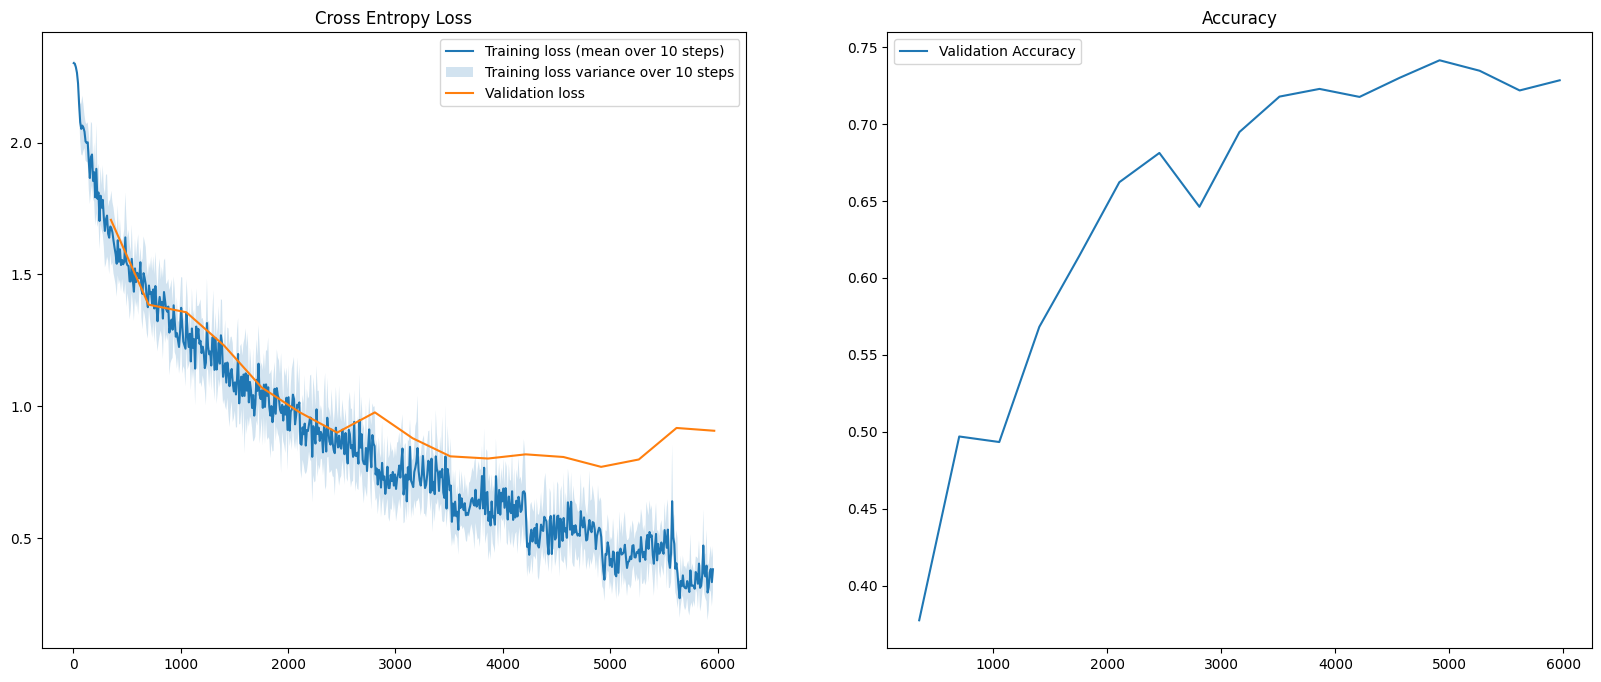

In [7]:
set_seed(0)
print(f"Using device: {get_device()}")
epochs = 10
batch_size = 64
learning_rate = 5e-2
early_stop_count = 4
dataloaders = load_cifar10(batch_size)
model = ExampleModel(image_channels=3, num_classes=10)
trainer = Trainer(
    batch_size, learning_rate, early_stop_count, epochs, model, dataloaders
)
trainer.train()
create_plots(trainer, "task2")